  This will be a data analysis of attacks on AWS Honeypot servers from Kaggle. A Honeypot is a server intentionally set up to be attacked, in an attempt to 'trap' or detect attackers. We will examine the attacks by target location, time, protocol, country of origin and other factors; drawing conclusions about which servers are most likely to experience attacks, which attack times are most common (and do these attack times coincide with high traffic times), and where these attacks are likely to originate. We should expect to see a greater number of attacks on high traffic servers during high traffic times, and we would expect to see most attacks come from countries known for launching cyberattacks on American servers, such as Russia and China.
  In this report I will attempt to answer several questions: which countries do most attacks originate from? What times (months and times of day) are most common for attacks? Can we determine what types of attacks are occuring from the data? Can we correlate times with country of origin?

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
aws_df = pd.read_csv('AWS_Honeypot_marx-geo.csv')
aws_df.info()
aws_df.head()
#Let's import the csv and take a look at some of the data we have available to us

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451581 entries, 0 to 451580
Data columns (total 16 columns):
datetime       451581 non-null object
host           451581 non-null object
src            451581 non-null int64
proto          451581 non-null object
type           44811 non-null float64
spt            406770 non-null float64
dpt            406770 non-null float64
srcstr         451581 non-null object
cc             447985 non-null object
country        447947 non-null object
locale         342112 non-null object
localeabbr     331705 non-null object
postalcode     86478 non-null object
latitude       448112 non-null float64
longitude      448153 non-null float64
Unnamed: 15    83 non-null float64
dtypes: float64(6), int64(1), object(9)
memory usage: 55.1+ MB


,datetime,host,src,proto,type,spt,dpt,srcstr,cc,country,locale,localeabbr,postalcode,latitude,longitude,Unnamed: 15
0,3/3/13 21:53,groucho-oregon,1032051418,TCP,NaN,6000.0,1433.0,61.131.218.218,CN,China,Jiangxi Sheng,36,NaN,28.5500,115.9333,NaN
1,3/3/13 21:57,groucho-oregon,1347834426,UDP,NaN,5270.0,5060.0,80.86.82.58,DE,Germany,NaN,NaN,NaN,51.0000,9.0000,NaN
2,3/3/13 21:58,groucho-oregon,2947856490,TCP,NaN,2489.0,1080.0,175.180.184.106,TW,Taiwan,Taipei,NaN,NaN,25.0392,121.5250,NaN
3,3/3/13 21:58,groucho-us-east,841842716,UDP,NaN,43235.0,1900.0,50.45.128.28,US,United States,Oregon,OR,97124,45.5848,-122.9117,NaN
4,3/3/13 21:58,groucho-singapore,3587648279,TCP,NaN,56577.0,80.0,213.215.43.23,FR,France,NaN,NaN,NaN,48.8600,2.3500,NaN


In [3]:
aws_df.tail()

,datetime,host,src,proto,type,spt,dpt,srcstr,cc,country,locale,localeabbr,postalcode,latitude,longitude,Unnamed: 15
451576,9/8/13 5:54,groucho-oregon,1922977453,TCP,NaN,62175.0,445.0,114.158.78.173,JP,Japan,Tokyo-to,13,NaN,35.6850,139.7514,NaN
451577,9/8/13 5:50,groucho-eu,1017974360,TCP,NaN,6000.0,8090.0,60.173.14.88,CN,China,Anhui Sheng,34,NaN,31.8639,117.2808,NaN
451578,9/8/13 5:55,groucho-oregon,3234358955,TCP,NaN,6000.0,1433.0,192.200.102.171,US,United States,California,CA,90017,34.0530,-118.2642,NaN
451579,9/8/13 5:55,groucho-tokyo,28142724,TCP,NaN,3555.0,445.0,1.173.108.132,TW,Taiwan,Taipei,NaN,NaN,25.0392,121.5250,NaN
451580,9/8/13 5:55,groucho-tokyo,28142724,TCP,NaN,3555.0,445.0,1.173.108.132,TW,Taiwan,Taipei,NaN,NaN,25.0392,121.5250,NaN


This is an extremely large dataset, with over 450,000 individual points. The datetime column is clearly the date and time of the attack; the dates appear to range over about a 6 month period, from March to September, and the times are listed in 24 hour format. This will be useful information for later processing. The host is the server which was attacked. The src column seems to be somewhat of a mystery, and this information was not listed on Kaggle. Proto is the protocol which was used. Type appears to have a lot of missing values, and will likely not be very innsightful. Spt is the source port and dpt is the destination port, since ports can be translated and masked this information will not likely glean a lot, but we know common ports, such as 80 for HTTP and 443 for HTTPS. Srcstr is going to be a source IP address, again, since IP addresses are easily masked, proxied and spoofed, this will likely not provide much useful information. CC is Country code, and Country is just the longform version of the CC column. Locale, where available, is a more specific location, such as a city, province or state within the US. The localeabbr is just a shorthand version of the previous version, and postalcode applies only to the US. Lattitude and Longitude are fairly self explanatory, but based on the other information available, I don't expect we will use these much.
Lets start by taking closer a look at the Protocol column.

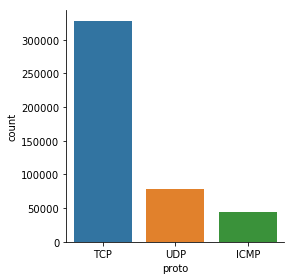

In [5]:
sns.factorplot(x='proto',data=aws_df,kind='count')

For those unfamiliar, TCP is the transmission control protocol, it is a connection oriented protocol with guaranteed delivery. UDP is the user datagram protocol, which is a connectionless protocol and does not error check to ensure packets were successfully delivered. ICMP is the internet control message protocol. ICMP attacks can be used to map a target network, this can be done with simple ping and traceroute commands, or with tools like NMAP. While these sorts of network scanning attacks are very useful for information gathering they are also noisy, which might indicate a factor as to why they are less common. Other attacks over ICMP include an ICMP flood, which can result in denial of service. UDP attacks include a UDP flood which can rsult in denial of service. TCP attacks include several methods of denial of service, as well as other attacks such as session hijacking. Denial of service is one of the most common types of attacks as it is simple and easy to carry out, since TCP is used by so many services, it makes sense that this would be several magnitudes greater than UDP or ICMP.
Next, lets look at the attack vectors, the sources of the attacks, and the destinations.

In [6]:
aws_df['host'].value_counts()

groucho-tokyo        126189
groucho-oregon        94076
groucho-singapore     78151
groucho-us-east       31779
groucho-norcal        24566
groucho-sydney        24456
groucho-sa            24316
zeppo-norcal          24094
groucho-eu            23954
Name: host, dtype: int64

In [7]:
aws_df['cc'].value_counts()

CN    191394
US     90005
JP     17204
IR     13042
TW     12150
NL     10739
IN      9418
KR      9316
VN      7826
RU      7211
DE      6573
BR      6370
CA      5983
HK      4488
GB      3951
FR      3928
RO      3075
SE      2964
TR      2299
SG      2202
UA      2162
TH      1839
IT      1798
AU      1713
VE      1603
BG      1567
ID      1416
AR      1385
PL      1309
ES      1285
       ...  
FJ         6
SR         5
MP         5
ML         4
NC         4
HT         4
QA         4
GU         4
VC         4
GD         3
BW         3
LS         3
WS         3
FM         2
AD         2
JE         2
LR         2
BF         2
YE         2
GQ         2
SM         2
GY         2
RW         2
BI         2
ET         2
PW         2
NE         2
CV         1
BB         1
BM         1
Name: cc, Length: 176, dtype: int64

In [31]:
aws_df.describe()

,src,type,spt,dpt,latitude,longitude,Unnamed: 15
count,4.515810e+05,44811.000000,406770.000000,406770.000000,448112.000000,448153.000000,83.000000
mean,2.154902e+09,7.514896,18685.461494,6684.258212,36.214115,48.751751,-77.027536
std,1.081011e+09,1.799866,19290.141746,14032.839799,194.251441,91.774739,0.011942
min,1.677725e+07,0.000000,0.000000,0.000000,-43.533300,-175.000000,-77.059600
25%,1.169129e+09,8.000000,6000.000000,445.000000,30.666700,-4.000000,-77.036400
50%,2.031191e+09,8.000000,6000.000000,1433.000000,35.685000,106.000000,-77.036400
75%,3.164988e+09,8.000000,33461.000000,3389.000000,40.455500,118.777800,-77.014600
max,3.758094e+09,13.000000,65535.000000,65500.000000,20076.000000,178.416700,-77.014600


As expected, it makes sense that China is at the top of the list, and Iran being fourth. The US being second is not surprising, however, I was surprised to see Japan as number three, and Russia all the way down at number 10.
The host servers data is also surprising, I would not have expected to see Tokyo at the top, and Oregon being second, especially since in my experience with AWS, the US-East servers see a lot of traffic. 
These descriptive statistics are not very useful, as even the numerical data are such that knowing the means and percentiles are not very useful. If we can extract simply the month or time of day from the datetime column, the descriptive statistics about those might be more useful.

In [29]:
china = aws_df[aws_df['cc']=='CN']
china

,datetime,host,src,proto,type,spt,dpt,srcstr,cc,country,locale,localeabbr,postalcode,latitude,longitude,Unnamed: 15
0,3/3/13 21:53,groucho-oregon,1032051418,TCP,NaN,6000.0,1433.0,61.131.218.218,CN,China,Jiangxi Sheng,36,NaN,28.5500,115.9333,NaN
6,3/3/13 21:59,groucho-oregon,3730416887,TCP,NaN,6000.0,1433.0,222.89.164.247,CN,China,Henan Sheng,41,NaN,34.6836,113.5325,NaN
7,3/3/13 22:07,groucho-singapore,3738622573,TCP,NaN,6000.0,3306.0,222.214.218.109,CN,China,Sichuan Sheng,51,NaN,30.6667,104.0667,NaN
8,3/3/13 22:12,groucho-oregon,3683919430,TCP,NaN,6000.0,1433.0,219.148.38.70,CN,China,Hebei,13,NaN,39.8897,115.2750,NaN
9,3/3/13 22:14,groucho-singapore,1007884304,TCP,NaN,6000.0,1433.0,60.19.24.16,CN,China,Liaoning,21,NaN,41.7922,123.4328,NaN
11,3/3/13 22:20,groucho-oregon,1965603898,TCP,NaN,9907.0,1433.0,117.40.188.58,CN,China,Jiangxi Sheng,36,NaN,28.5500,115.9333,NaN
19,3/3/13 22:26,groucho-tokyo,1965603898,TCP,NaN,26180.0,1433.0,117.40.188.58,CN,China,Jiangxi Sheng,36,NaN,28.5500,115.9333,NaN
20,3/3/13 22:29,groucho-eu,3683780686,UDP,NaN,54790.0,5060.0,219.146.8.78,CN,China,Shandong Sheng,37,NaN,36.6683,116.9972,NaN
28,3/3/13 22:42,groucho-oregon,1017977401,TCP,NaN,6000.0,1433.0,60.173.26.57,CN,China,Anhui Sheng,34,NaN,31.8639,117.2808,NaN
30,3/3/13 22:45,groucho-oregon,2073368071,TCP,NaN,6000.0,1433.0,123.149.22.7,CN,China,Henan Sheng,41,NaN,34.6836,113.5325,NaN


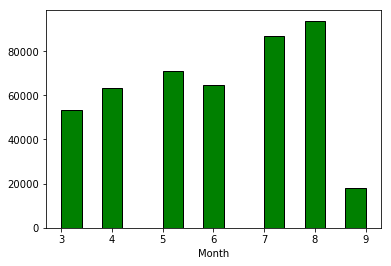

In [131]:
DateTimes = aws_df['datetime'].str.split(' ')
Times = DateTimes.str.get(1)
Dates = DateTimes.str.get(0)
Times = Times.str.replace(':', '')
Hours = [x[:-2] for x in Times]
intTimes =[]
intMonths = []
intHours = []
for hour in Hours:
    integer = int(hour)
    intHours.append(integer)
for time in Times:
    integer = int(time)
    intTimes.append(integer)
for date in Dates:
    month = date[0][0]
    integer = int(month)
    intMonths.append(integer)
plt.hist(intMonths, bins=15, color='green', edgecolor='k')
plt.xlabel('Month')
plt.show()

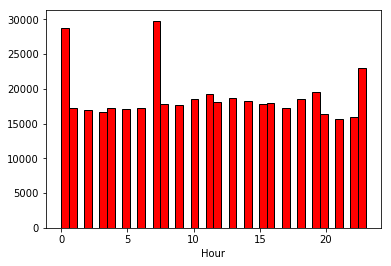

In [133]:
plt.hist(intHours, bins=40, color='red', edgecolor='k')
plt.xlabel('Hour')
plt.show()

For the most part, the number of attacks per month seems to be close to the same with more attacks occurring in July and August than others. The fact that September has so many fewer than the other months can be explained by looking at the tail of the data; it appears that the data collection ended early in the month, so this explains the discrepancy. We see that time of day is pretty universal, with spikes around 00:00, 07:00, and 23:00. It's a shame there doesn't appear to be information about where this time was recorded from, is it UTC, or local time to the server which logged the attempt? It's hard to make much more useful insight without this information.

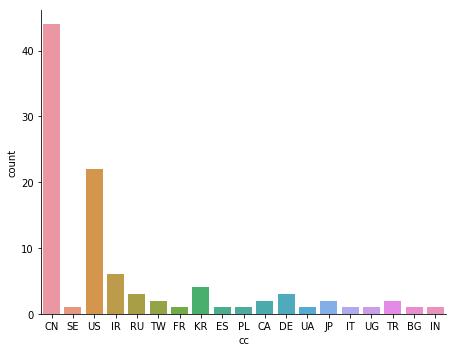

In [153]:
cc = aws_df['cc']
countrytime_df = DataFrame(intHours,cc)
sample1 = aws_df.sample(100)
sns.factorplot(x='cc',data=sample1,kind='count',size=5, aspect=1.25)

We were able to glean some interesting information from this dataset. Given more time we could create plots of the times of attacks vs. country of origin, or target country; plots of country vs. protocol; and perhaps plots of country vs port